In [15]:
## STEP 0: Import libs, create functions
# We will need the RBCPath type from the rbclib package to load data from the RBC.
from rbclib import RBCPath

# We'll also want to load some data directly from the filesystem.
from pathlib import Path

# We'll want to load/process some of the data using pandas and numpy.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_fsdata(participant_id, local_cache_dir=(Path.home() / 'cache')):
    "Loads and returns the dataframe of a PNC participant's FreeSurfer data."

    # Check that the local_cache_dir exists and make it if it doesn't.
    if local_cache_dir is not None:
        local_cache_dir = Path(local_cache_dir)
        local_cache_dir.mkdir(exist_ok=True)
    
    # Make the RBCPath and find the appropriate file:
    pnc_freesurfer_path = RBCPath(
        'rbc://PNC_FreeSurfer/freesurfer',
        # We provide the local_cache_dir to the RBCPath object; all paths made
        # from this object will use the same cache directory.
        local_cache_dir=local_cache_dir)
    participant_path = pnc_freesurfer_path / f'sub-{participant_id}'
    tsv_path = participant_path / f'sub-{participant_id}_regionsurfacestats.tsv'

    # Use pandas to read in the TSV file:
    with tsv_path.open('r') as f:
        data = pd.read_csv(f, sep='\t')

    # Return the loaded data:
    return data

In [3]:
def load_acc_corthick(participant_id):
    "Loads and returns the bilateral Anterior Cingulate Cortex (ACC) average thickness for a PNC study participant."
    
    # First, load the subject's FreeSurfer dataframe:
    data = load_fsdata(participant_id)
    # Next, find the relevant rows:
    row_mask = ((data['StructName'] == 'Brodmann.24') | (data['StructName'] == 'Brodmann.32') | (data['StructName'] == 'Brodmann.33'))
    # Then extract and sum the surface areas:
    acc_corthick = data.loc[row_mask, 'ThickAvg']
    acc_corthick_mean = np.mean(acc_corthick)
    # And return this value:
    return acc_corthick_mean

In [4]:
example_participant_id = 1000393599
test = load_acc_corthick(example_participant_id)
test

3.048

In [5]:
# Participant meta-data is generally located in the BIDS repository for each
# study:
rbcdata_path = Path('/home/jovyan/shared/data/RBC')
train_filepath = rbcdata_path / 'train_participants.tsv'
test_filepath = rbcdata_path / 'test_participants.tsv'

# Load the PNC participants TSV files...
with train_filepath.open('r') as f:
    train_data = pd.read_csv(f, sep='\t')
with test_filepath.open('r') as f:
    test_data = pd.read_csv(f, sep='\t')

# We can also concatenate the two datasets into a single dataset of all
# study participants:
all_data = pd.concat([train_data, test_data])

In [6]:
# First load in surface area data for each participant:
print("Loading structural data...")     

# We will put the rows in this dictionary of lists as we build the dataframe:
all_vars = {
    'participant_id': [],
    'acc_cor_thick': [],
    'p_factor': []}

# We'll display a progress bar `prog` as we go also:
from ipywidgets import IntProgress
prog = IntProgress(min=0, max=len(all_data))
display(prog)

# Okay, loop through each row of the `all_data` dataframe, which contains both
# training and test subjects, load their BA1 data, and store it in the
# all_vars dictionary.
for (ii, row) in all_data.iterrows():
    # Extract the participant ID and p_factor (which will be NaN for test
    # participants).
    participant_id = row['participant_id']
    p_factor = row['p_factor']
    
    # Load the surface area for this participant:
    try:
        acc_cor_thick = load_acc_corthick(participant_id)
    except FileNotFoundError:
        # Some subjects are just missing the file, so we code them as NaN.
        acc_cor_thick = np.nan
    
    # Append the participant ID and their surface area to our dataset:
    all_vars['participant_id'].append(participant_id)
    all_vars['acc_cor_thick'].append(acc_cor_thick)
    all_vars['p_factor'].append(p_factor)
    # Increment the progress bar counter:
    prog.value += 1

# Convert train_vars into a dataframe.
all_vars = pd.DataFrame(all_vars)

# Extract the training and test subjects into separate dataframes; the test
# participants can be identified as those having NaN values for their
# p_factor column.
train_vars = all_vars[~np.isnan(all_vars['p_factor'])]
test_vars = all_vars[np.isnan(all_vars['p_factor'])]

# Display the finished dataframe.
all_vars

Loading surface areas...


IntProgress(value=0, max=1601)

,participant_id,acc_cor_thick,p_factor
0,1000393599,3.0480,0.589907
1,1001970838,2.7498,-0.659061
2,1007995238,2.8656,-1.608375
3,1011497669,2.9308,-1.233807
4,1017092387,2.9474,-0.923100
...,...,...,...
1596,969649154,3.0190,NaN
1597,970890500,3.1330,NaN
1598,975856179,2.9132,NaN
1599,984757368,2.7072,NaN


In [7]:
# Import the LinearRegression type:
from sklearn.linear_model import LinearRegression

# LinearRegression requires a matrix whose columns are the variables and whose
# final column is the value being predicted (the p_factor for us). We can
# extract these columns straight from the dataframes we generated.
train_matrix = train_vars.loc[:, ['acc_cor_thick', 'p_factor']].values
# We need to exclude rows with NaNs for training:
train_okrows = np.all(~np.isnan(train_matrix), axis=1)
train_matrix = train_matrix[train_okrows]

# Train the regression using the training matrix:
lreg = LinearRegression()
lreg.fit(train_matrix[:, :1], train_matrix[:, 1])

# Display the trained regression parameters:
print("Linear Regression:")
print("  Intercept:", lreg.intercept_)
print("  Slope:", lreg.coef_)

Linear Regression:
  Intercept: 1.4797547415026648
  Slope: [-0.66041464]


In [8]:
# We can apply the trained linear regression object `lreg` to the 1-column
# matrix of ba1_surface_area values in the test_vars dataframe.
test_matrix = test_vars.loc[:, ['acc_cor_thick']].values
test_okrows = np.all(~np.isnan(test_matrix), axis=1)
test_matrix = test_matrix[test_okrows]

# Apply the model:
p_factor_predictions = lreg.predict(test_matrix)

# Display the predictions:
p_factor_predictions

array([-0.4564489 , -0.47560093, -0.38195413, -0.47454426, -0.52552827,
       -0.60543845, -0.54243489, -0.35553755, -0.6212884 , -0.38670912,
       -0.39727575, -0.38710537, -0.45922264, -0.4417877 , -0.49541337,
       -0.44350478, -0.49105463, -0.5563036 , -0.57413479, -0.47401593,
       -0.59328682, -0.37931247, -0.54375572, -0.40572906, -0.49845127,
       -0.37416124, -0.40321948, -0.48616756, -0.39780408, -0.55194486,
       -0.37376499, -0.58007852, -0.42171109, -0.56528524, -0.3605567 ,
       -0.40718197, -0.52235828, -0.38446371, -0.55273736, -0.38406746,
       -0.42910774, -0.44073103, -0.41695611, -0.69116027, -0.46556262,
       -0.71691644, -0.31168601, -0.48286549, -0.39423784, -0.57822936,
       -0.50254584, -0.3659721 , -0.38961494, -0.55141653, -0.60953302,
       -0.43888187, -0.34457466, -0.49396045, -0.45156183, -0.36134919,
       -0.53715157, -0.53635907, -0.4069178 , -0.32410181, -0.31234643,
       -0.50531959, -0.44007062, -0.39040744, -0.53477408, -0.45

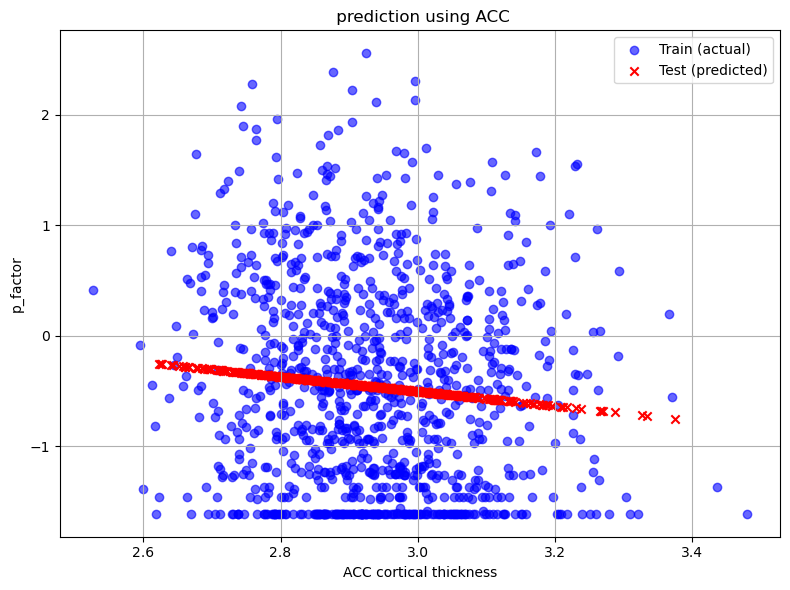

In [19]:
# Plot

X_train = train_matrix[:, :1]
y_train = train_matrix[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color='blue', label='Train (actual)', alpha=0.6)
plt.scatter(test_matrix, p_factor_predictions, color='red', label='Test (predicted)', marker='x')
plt.xlabel(f'ACC cortical thickness')
plt.ylabel(f'p_factor')
plt.title(f' prediction using ACC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
test_data.loc[test_okrows, 'p_factor'] = p_factor_predictions

# Display the resulting test data:
test_data

,participant_id,study,study_site,session_id,wave,age,sex,race,ethnicity,bmi,handedness,participant_education,parent_1_education,parent_2_education,p_factor,internalizing_mcelroy_harmonized_all_samples,externalizing_mcelroy_harmonized_all_samples,attention_mcelroy_harmonized_all_samples,cubids_acquisition_group
0,1000881804,PNC,PNC1,PNC1,1,14.916667,Male,Black,not Hispanic or Latino,21.52,Right,7th Grade,Complete secondary,Complete secondary,-0.456449,0.097355,0.387355,-0.467807,113
1,100527940,PNC,PNC1,PNC1,1,8.250000,Male,Black,not Hispanic or Latino,NaN,Ambidextrous,1st Grade,Complete secondary,Complete primary,-0.475601,0.699062,-0.781881,-0.982040,3
2,1006151876,PNC,PNC1,PNC1,1,21.500000,Female,Other,not Hispanic or Latino,NaN,Right,12th Grade,Complete tertiary,Complete secondary,-0.381954,0.495947,0.806481,-0.832210,1
3,1012530688,PNC,PNC1,PNC1,1,8.750000,Male,Black,not Hispanic or Latino,21.36,Right,2nd Grade,Complete tertiary,Complete secondary,-0.474544,-0.334835,1.277773,0.161110,4
4,1030193285,PNC,PNC1,PNC1,1,18.000000,Male,White,not Hispanic or Latino,22.15,Right,10th Grade,Complete secondary,Complete primary,-0.525528,1.027404,-0.490472,2.014568,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,969649154,PNC,PNC1,PNC1,1,12.333333,Male,White,not Hispanic or Latino,17.38,Right,5th Grade,Complete tertiary,Complete secondary,-0.514037,-0.148520,0.556444,0.024228,1
530,970890500,PNC,PNC1,PNC1,1,18.166667,Female,White,not Hispanic or Latino,30.89,Right,11th Grade,Complete secondary,Complete secondary,-0.589324,0.993806,1.578177,-0.373470,1
531,975856179,PNC,PNC1,PNC1,1,11.000000,Male,White,not Hispanic or Latino,15.67,Right,4th Grade,Complete primary,Complete secondary,-0.444165,-1.026645,-0.582212,1.333857,1
532,984757368,PNC,PNC1,PNC1,1,13.416667,Male,Black,not Hispanic or Latino,16.66,Right,5th Grade,Complete primary,NaN,-0.308120,0.360029,-0.515655,1.509584,114


In [10]:
# The sep='\t' option here is necessary for tab-separated-value (as opposed to
# comma-separated-value) files. The `index=False` just indicates that pandas
# doesn't need to write out its own index column.

group_name = 'group7'  # Change this to be your group name!

test_data.to_csv(f'results/{group_name}.tsv', sep='\t', index=False)